# Suite of Perception Experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
%matplotlib inline

import scipy

import warnings
warnings.filterwarnings("ignore")

import lqr
import linear_system as lin
import pipeline as pipe
import synthesis as syn
import training

In [4]:
### Dynamics
dt = 0.05
ndims = 2
nx = 2 * ndims
del_ref = 1

q = 5
norm = np.inf 

A, B, C = lin.double_integrator_dynamics(dt, ndims=ndims, q=None)
Q, R = lqr.lqr_parameters(q, ndims=ndims)
srQ = scipy.linalg.sqrtm(Q); srR = scipy.linalg.sqrtm(R)

K = lqr.lqr_inf_horizon(A, B, Q, R)[0]
Tmax = 200 # FIR horizon for SLS

### Observation
n_px = 48 # dim of image
dot_width = 0.06 # size of dot (between 0 and 1)
im_noise = 0.01 # percent noise (between 0 and 1)

In [5]:
def get_obs(xs): # xs is (N, nx)
    ims = np.array([pipe.loc2im((x[0], x[2]), n_px, dot_width, im_noise).flatten() for x in xs])
    return ims
#     zs = np.hstack((np.ones((ims.shape[0], 1)), ims))
#     return zs

def get_traj_xs(x0, T, freq, amp, exp_noise):
    ref = np.zeros((T, x0.shape[0]))
    theta = np.linspace(0, freq*np.pi, T)
    ref[:,0] = amp * np.cos(theta)
    ref[:,2] = amp * np.sin(theta)
    xds = np.zeros(ref.shape)
    xds[0] = x0
    wds = np.random.standard_normal(ref.shape) * exp_noise # "exploration noise"
    for k in range(T-1):
        u = -K.dot(xds[k] - ref[k])
        xds[k+1] = A.dot(xds[k]) + B.dot(u) + wds[k]
    return xds, ref

def get_random_xs(T, r):
    return np.random.uniform(low=-r, high=r, size=(T, nx)), None

def get_xs(mode, params):
    return get_random_xs(**params) if mode == 'random' else get_traj_xs(**params)
    
def get_training_data(xs):
    return get_obs(xs), C.dot(xs.T).T

## Fitting Perception Module

### Comparing different Ps and their error models, ultimately to be used in control synthesis

We compare regularized ($\lambda = 10^{-3}$) with not regularizing. Our baseline is ridge regression.

Method:
- (To find the best $\lambda$): For a fixed $\alpha$, we successively train on train set, validate on test set. 
    - our objective is $\alpha \varepsilon_C + (1 - \alpha)\varepsilon_\eta$ 
- Once an adequately good $\lambda$ is found, train perception $p$ on entire train + test data.
- Fit the error model $p(z) = \Delta_C x + \eta$ using trained $p$ on the validation set.

Notes:
- Doing golden section search on $\lambda$ gives around $10^{-3}$; we choose this instead of refitting for every new dataset.
- There is an abrupt jump in optimal error model as we increase $\alpha$, where either the optimal $\varepsilon_C$ is essentially 0, or the optimal $\varepsilon_C$ is around 0.2

In [6]:
### Data
debug = False
T = 200
r = 0.25
freq = 6
amp = 0.3
exp_noise = 1.5e-2
x0 = np.array([0.4, 0, 0.1, 0])

param_dict = {
    'random': dict(T=T, r=r),
    'tracking': dict(x0=x0, T=T, freq=freq, amp=amp, exp_noise=exp_noise)
}

mode = 'tracking'

## Generating train/test
xtrain, ref = get_xs(mode, param_dict[mode])
xtest, _ = get_xs(mode, param_dict[mode])
xval, _ = get_xs(mode, param_dict[mode])
xhold, _ = get_xs(mode, param_dict[mode])

ztrain, ytrain = get_training_data(xtrain)
ztest, ytest = get_training_data(xtest)
zval, yval = get_training_data(xval)
zhold, yhold = get_training_data(xhold)

xd, zd = np.vstack((xtrain, xtest)), np.vstack((ztrain, ztest))

if debug:
    pipe.plot_coordinate_data([xtrain, xtest, xval, xhold],
                             ['train', 'test', 'val', 'hold'])
    pipe.plot_image_data(zd, zval, n_px)

In [500]:
suffix = 'r_%.3f' % r if mode == 'random' else 'noise_%.3f' % exp_noise
data_fname = 'data/%s_training_%s.npz' % (mode, suffix)

overwrite = False
rerun = False

norm = np.inf

test_params = {
    'smooth': dict(alpha=0.1, reg=2e-3, robust=True),
    'ridge': dict(alpha=0.1, reg=1e-4, robust=False)
}

Ps = {}; errs_tr = {}; errs_val = {};

if not rerun and os.path.exists(data_fname):
    print('loading data from', data_fname)
    data_dict = np.load(data_fname)
    ref = data_dict.get('ref', ref)
    xval = data_dict['xval']; zval = data_dict['zval']; 
    xhold = data_dict['xhold']; zhold = data_dict['zhold'];
    xtrain = data_dict['xtrain']; ztrain = data_dict['ztrain']; 
    xtest = data_dict['xtest']; ztest = data_dict['ztest'];
    xd, zd = np.vstack((xtrain, xtest)), np.vstack((ztrain, ztest))

    for name in test_params.keys():
        Ps[name] = data_dict['P_%s' % name]
        errs_tr[name] = data_dict['err_tr_%s' % name]
        errs_val[name] = data_dict['err_val_%s' % name]

test_params[name]['alpha'] = pipe.compute_alpha(xd, norm)
print(test_params[name]['alpha'])

loading data from data/random_training_r_0.250.npz
0.1692489697482903


In [501]:
for name, args in test_params.items():
    print(args)
    if name not in Ps:
        Ps[name] = training.train_P((xd, zd), C, *args)[0]
        errs_tr[name] = training.fit_error_model((xval, zval), C, P, args['alpha'])[1]
        errs_val[name] = training.fit_error_model((xhold, zhold), C, P, args['alpha'])[1]

    P = Ps[name]
    err_tr = errs_tr[name]
    err_val = errs_val[name]
    
    pnorm = np.linalg.norm(P, norm)
    print("eps_C train: {}, |P|: {}".format(err_tr[0], pnorm))
    print("eps_C val: {}, |P|: {}".format(err_val[0], pnorm))

{'alpha': 0.1, 'reg': 0.002, 'robust': True}
eps_C train: 0.005977556316193871, |P|: 3.2399994606161195
eps_C val: 0.25012186951084076, |P|: 3.2399994606161195
{'alpha': 0.1692489697482903, 'reg': 0.0001, 'robust': False}
eps_C train: 6.046446153275936e-06, |P|: 5.87259447266713
eps_C val: 0.1266944558015637, |P|: 5.87259447266713


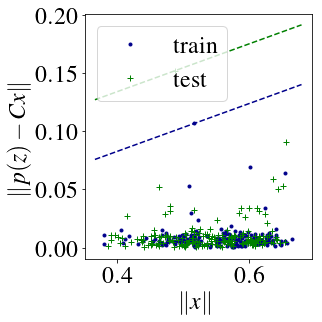

In [486]:
fontsize = 24
plt.rc('font', size=fontsize)
plt.rcParams['legend.fontsize'] = fontsize
for i, name in enumerate(test_params.keys()):
    P = Ps[name]
    datasets = [
        dict(x=xval, y=zval.dot(P.T), label='train', marker='.', color='darkblue'),
        dict(x=xhold, y=zhold.dot(P.T), label='test', marker='+', color='green'),
    ]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    pipe.plot_err_vs_norm(ax, datasets, errs_tr[name], C)
    plt.tight_layout()
    fig.savefig('../paper/figures/%s_training_%s_%s.pdf' % (mode, name, suffix))

In [444]:
print('saving data to %s' % data_fname)
data_dict = {'xtrain': xtrain, 'ztrain': ztrain,
             'xtest': xtest, 'ztest': ztest,
             'xval': xval, 'zval': zval, 
             'xhold': xhold, 'zhold': zhold,
             'ref': ref}
for name in test_params.keys():
    data_dict['P_%s' % name] = Ps[name]
    data_dict['err_tr_%s' % name] = errs_tr[name]
    data_dict['err_val_%s ' % name] = errs_val[name]
np.savez(data_fname, **data_dict)

saving data to data/tracking_training_noise_0.020.npz


## Control synthesis

In [489]:
## Synthesize controllers

rerun = False
debug = False
sx = 0.5
sy = 0.5

save = True

controllers = {}
control_params = {
    'L1 robust': dict(T=200, norm='l1', wx=sx, wy=sy, 
                      Ld=0.5, wc=0.1, solver='MOSEK'),
    'LQG robust': dict(T=200, norm='h2', wx=sx, wy=sy,
                      Ld=0.3, wc=0.05, solver='MOSEK'),
    'L1 nominal': dict(T=200, norm='h2', wx=sx, wy=sy,
                      Ld=None, wc=None),
    'LQG nominal': dict(T=200, norm='l1', wx=sx, wy=sy,
                       Ld=None, wc=None),
}

param_str = '_'.join([('%s_%.1f_%.2f_%d' % (ps['norm'], ps['Ld'], ps['wc'], ps['T']))\
                      for ps in control_params.values() if ps['robust']])
sys_fname = 'data/controllers_%.2f_%.2f_%s.npz' % (sx, sy, param_str)

if not rerun and os.path.exists(sys_fname):
    controllers = pipe.load_system(sys_fname, A)

for name, params in control_params.items():
    if name in controllers:
        continue
    sys, prob = synth.synthesize_perception_controller(A, B, C, Q, R, **params)
    controllers[name] = sys
    print(name, params, prob)

l1_0.5_0.10_200_h2_0.3_0.05_200
L1 robust {'T': 200, 'norm': 'l1', 'Ld': 0.5, 'wc': 0.1, 'wx': 0.5, 'wy': 0.5, 'solver': 'MOSEK'} (array(224.272), 'optimal')
using l1 of transpose instead of h inf norm
LQG robust {'T': 200, 'norm': 'h2', 'Ld': 0.3, 'wc': 0.05, 'wx': 0.5, 'wy': 0.5, 'solver': 'MOSEK'} (1161.8955083826838, 'optimal')
L1 nominal {'T': 200, 'norm': 'h2', 'wx': 0.5, 'wy': 0.5} (346.59695564399857, 'optimal')
LQG {'T': 200, 'norm': 'l1', 'wx': 0.5, 'wy': 0.5} (array(71.332), 'optimal')


In [472]:
def proc_fnc(x, u):
    wx = np.sign(B.dot(u)) * sx if mode == 'random' else 0
    return A.dot(x) + B.dot(u) + wx

def obs_fnc_generator(P):
    def obs_fnc(x):
        z = get_obs([x])
        y = z.dot(P.T).flatten()
        return y, z
    return obs_fnc

In [502]:
rerun = False

T = 150
n_rollouts = 200
# n_rollouts = 20

if mode is 'tracking':
    start_noise = 1e-1
    x0s = np.clip(xval[0] + start_noise * np.random.standard_normal((n_rollouts, A.shape[0])), -0.48, 0.48)
    ref = ref
else:
    start_noise = r*1.6
    x0s, ref = get_random_xs(n_rollouts, start_noise)

rollout_fname = 'data/%s_%drollouts_startnoise_%.2f.npz' % (mode, n_rollouts, start_noise)

skip_rollout = ['nonsmooth', 'ridge']

all_rollouts = {}

if not rerun and os.path.exists(rollout_fname):
    print('loading rollouts')
    all_rollouts = pipe.load_rollouts(rollout_fname, skip_rollout)
else:     
    print('running rollouts')
    for name in test_params.keys():
        obs_fnc = obs_fnc_generator(Ps[name])
        all_rollouts[name] = pipe.run_rollouts(controllers, A, B, C, T, x0s, ref, proc_fnc, obs_fnc)

loading rollouts
loading rollouts from data/random_200rollouts_startnoise_0.40.npz
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge
skipping rollouts for ridge


saved figure 1 to ../paper/figures/random_smooth_xerr_200rollouts_all.pdf
saved figure 2 to ../paper/figures/random_smooth_yerr_200rollouts_all.pdf


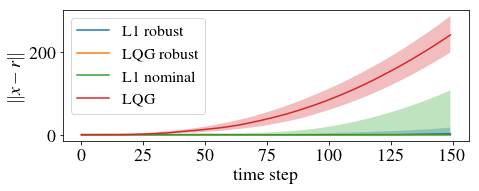

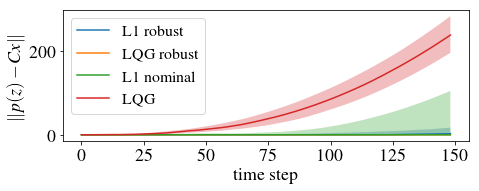

In [503]:
figs = {}
no_plot = []
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('font', serif='Times')
plt.rc('font', size=18)
plt.rcParams['legend.loc'] = 'upper left'
plt.rcParams['legend.fontsize'] = 16

figsize = (7, 3)
for name, rollouts in all_rollouts.items():
    if name is 'ridge':
        continue
    fig1, fig2 = pipe.plot_rollouts(rollouts, C, ref, figsize=figsize, skip_keys=no_plot)
    omit_str = 'omit_%s' % '_'.join(no_plot) if len(no_plot) > 0 else 'all'
    fname1 = '../paper/figures/%s_%s_xerr_%drollouts_%s.pdf' % (mode, name, n_rollouts, omit_str)
    fname2 = '../paper/figures/%s_%s_yerr_%drollouts_%s.pdf' % (mode, name, n_rollouts, omit_str)
    if True:
        fig1.tight_layout(); fig1.savefig(fname1); print('saved figure 1 to', fname1);
        fig2.tight_layout(); fig2.savefig(fname2); print('saved figure 2 to', fname2);

In [493]:
pipe.save_rollouts(rollout_fname, all_rollouts)
pipe.save_system(sys_fname, controllers)

saving all rollouts to data/tracking_200rollouts_startnoise_0.10.npz


True

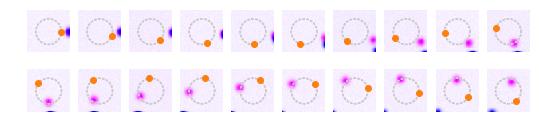

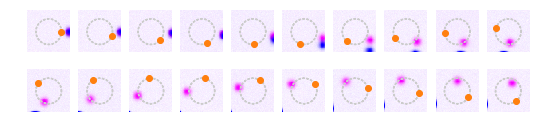

In [114]:
start = 0
step = 4
end = 8*10
for name, rollouts in all_rollouts.items(): # for each perception map
    z_h2r = rollouts['L1 robust']['zs'][0]
    z_h2 = rollouts['L1 nominal']['zs'][0]
    fig = plt.figure(figsize=(9, 2))
    pipe.plot_image_rollouts(fig, z_h2, z_h2r, ref, n_px, start, step, end)

## Finite time control costs 

In [52]:
def compute_trajectory_cost(xs, us, Q, R, norm):    
    if norm.upper() == 'H2':
        norm = 2
        mult = 1 / len(xs)
    elif norm.upper() == 'L1':
        norm = np.inf
        mult = 1
    else:
        raise NotImplementedError('norm not supported')
    # xs, us are (N, state/input dim)
    us = np.vstack((us, np.zeros(us.shape[1])))
    H = np.diag(xs.dot(Q).dot(xs.T) + us.dot(R).dot(us.T))
#     print(H.shape)
    return np.linalg.norm(H, ord=norm) * mult

(200, 160, 4)
(200, 160, 4)


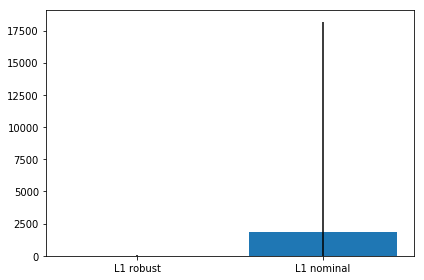

In [62]:
for name, rollout_dict in all_rollouts.items():
    if name is 'smooth':
        continue
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    labels = []
    bars = []
    errs = []
    for control, rollout in rollout_dict.items():
        norm = control.split()[0] # should be h2 or l1
        if norm.upper() == 'H2':
            continue
        xs, us = rollout['xs'], rollout['us']
        if ref is not None:
            xs = xs - ref[None,:T,:]
        print(xs.shape)
        costs = [compute_trajectory_cost(xs[i], us[i], Q, R, norm) for i in range(len(xs))]
        lo, med, hi = pipe.get_quartiles(costs)
        labels.append(control)
        bars.append(med)
        errs.append((med - lo, hi - lo))
    errs = np.array(errs).T
    xticks = np.arange(len(labels))
    ax.bar(xticks, bars, yerr=errs, tick_label=labels)
# plt.savefig('figures/l1_finite_cost_comparison_prelim.pdf')